In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
bzcat = pd.read_excel('data/bzcat_full.xlsx') # BZCAT provided in Excel
bzcat.drop(['id'], inplace=True, axis=1)
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN


### Getting the radio-to-optical spectral index from the original Roma-BZCAT dataset

In [3]:
# Getting spectral indices. Here bzcat5.dat is the original BZCAT dataset 
# Suggesting the order of objects are the same in both files!!!
sp_index = []
with open('data/bzcat5.dat') as f:
    for line in f:
        sp_index.append(float(line.split()[-1]))
bzcat['Rad_opt_sp_index'] = sp_index
bzcat['Rad_opt_sp_index'].replace(-9.9, np.NaN, inplace=True)  # NaN values
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,Rad_opt_sp_index
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,0.707
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,0.661
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,0.917


### Adding flux densities at 4.8 GHz

In [4]:
# Flux density average values from the CATS database
fluxd = pd.read_csv('data/bzcat_aver_fluxd_4.8.csv', sep=';')

# Data reorganizing
fluxd.rename(columns={'obj': 'Source', 'aver': 'Flux_density4.8'}, 
    inplace=True)
fluxd['Source'] = fluxd['Source'].apply(lambda x: x[0:13])
fluxd['Flux_density4.8'] = fluxd['Flux_density4.8'] * 1000  # to mJy

# "Mutual" source names for the datasets
bzcat['Source'] = bzcat.apply(lambda x:
    x['RA (J2000.0)'][0:2] + x['RA (J2000.0)'][3:5] + x['RA (J2000.0)'][6:8] \
    + x['Dec (J2000.0)'][0:3] + x['Dec (J2000.0)'][4:6] + x['Dec (J2000.0)'][7:9], 
    axis=1)

# Merging
bzcat = bzcat.merge(
    fluxd[['Source', 'Flux_density4.8',]], how='left',  on='Source')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,Rad_opt_sp_index,Source,Flux_density4.8
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,0.707,000020-322101,461.0
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,0.661,000105-155106,305.0
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,0.917,000108+191434,169.0


### Adding spectral indices

In [5]:
# Spectral indices from the CATS database
sp_indices = pd.read_csv('data/bzcat_sp_ind.csv', sep=';')

# Data reorganizing
sp_indices.rename(columns={
    'obj': 'Source', 
    '1,1-2,3': 'alpha_1.1-2.3',
    ' 2,3-4,7': 'alpha_2.3-4.8',
    ' 4,8-7,7/8,2': 'alpha_4.8-7.7',
    ' 4,7-11,2': 'alpha_4.8-11.2',
    ' 8,2/7,7-11,2': 'alpha_7.7-11.2',
    ' 11,2-21,7/22,3': 'alpha_11.2-21.7',
    ' 8,2/7,7-21,7': 'alpha_7.7-21.7',
    ' 4,7-22,3/21,3': 'alpha_4.8-21.7'}, 
    inplace=True)
sp_indices['Source'] = sp_indices['Source'].apply(lambda x: x[0:13])
sp_indices.replace(' - ', np.NaN, inplace=True)
col_to_float = [
    'alpha_1.1-2.3', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 'alpha_4.8-11.2',
    'alpha_7.7-11.2', 'alpha_11.2-21.7', 'alpha_7.7-21.7', 'alpha_4.8-21.7']
sp_indices[col_to_float] = sp_indices[col_to_float].astype(float)
sp_indices.drop(columns=['e', 'e.1', 'e.2', 'e.3', 'e.4', 'e.5', 'e.6', 'e.7'], 
                inplace=True)

# Merging
bzcat = bzcat.merge(sp_indices, how='left', on='Source')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,Source,Flux_density4.8,alpha_1.1-2.3,alpha_2.3-4.8,alpha_4.8-7.7,alpha_4.8-11.2,alpha_7.7-11.2,alpha_11.2-21.7,alpha_7.7-21.7,alpha_4.8-21.7
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,000020-322101,461.0,NaN,0.056,-0.763,NaN,NaN,NaN,-0.967,-0.903
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,000105-155106,305.0,NaN,-0.281,-0.599,-0.788,-1.028,0.366,-0.138,-0.282
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,000108+191434,169.0,-0.117,0.029,0.276,-0.427,-1.314,0.079,-0.425,-0.205


### Adding variability data

In [6]:
# Variability from the CATS database
var = pd.read_csv('data/bzcat_var.csv', sep=';')

# Data reorganizing
var.rename(columns={'obj': 'Source',
    '1,2': 'var_1.1', '2,3': 'var_2.3', '4,7': 'var_4.8',
    '8,2': 'var_7.7', '11,2': 'var_11.2', '22,3': 'var_21.7'},
    inplace=True)
var['Source'] = var['Source'].apply(lambda x: x[0:13])
var.replace([' - ', ' -'], np.NaN, inplace=True)
col_to_float = [
    'var_1.1', 'var_2.3', 'var_4.8', 'var_7.7', 'var_11.2', 'var_21.7']
var[col_to_float] = var[col_to_float].astype(float)

# Merging
bzcat = bzcat.merge(var, how='left', on='Source')

In [7]:
# Taking cleansed var_7.7 for BLCat objects 

var_blcat = pd.read_table('data/ExpVarCats.csv')
var_blcat.replace('-', np.NaN, inplace=True)
bzcat = bzcat.merge(
    var_blcat[['name', '7.7']], how='left', left_on='Source', right_on='name')
bzcat['7.7'] = bzcat['7.7'].astype(float)
bzcat['var_7.7'] = bzcat.apply(lambda x: 
    x['7.7'] if pd.notnull(x['name']) else x['var_7.7'], axis=1)
bzcat.drop(columns=['name', '7.7'], inplace=True)

bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,alpha_7.7-11.2,alpha_11.2-21.7,alpha_7.7-21.7,alpha_4.8-21.7,var_1.1,var_2.3,var_4.8,var_7.7,var_11.2,var_21.7
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,NaN,NaN,-0.967,-0.903,NaN,0.652,0.256,0.246,NaN,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,-1.028,0.366,-0.138,-0.282,NaN,0.499,0.303,0.333,NaN,0.387
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,-1.314,0.079,-0.425,-0.205,NaN,0.418,0.468,0.626,0.234,0.571


### Adding SDSS data

In [8]:
# Data scraped from the SDSS file via ./scraper_sdss.ipynb
sdss = pd.read_excel('data/SDSS_data.xlsx', dtype={'SDSS id': 'object'})

# Taking only the SDSS ugriz photometry and extinction from here. 
# Other features will be taken further from the original catalogs
sdss = sdss[['Source name', 'u', 'g', 'r', 'i', 'z', 'extinction_r']]
sdss.rename(columns={'Source name': 'BZCAT5 Source name'}, inplace=True)
bzcat = bzcat.merge(sdss, how='left', on='BZCAT5 Source name')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,var_4.8,var_7.7,var_11.2,var_21.7,u,g,r,i,z,extinction_r
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,0.256,0.246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.303,0.333,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.468,0.626,0.234,0.571,24.296,22.516,21.555,21.503,20.893,0.09


### Adding the PanSTARRS data

In [9]:
# Data obtained from the PanSTARRS site via online requests
pstarrs = pd.read_csv('data/PanSTARRS_0.csv')
pstarrs = pd.concat([pstarrs, pd.read_csv('data/PanSTARRS_1.csv')])
pstarrs = pd.concat([pstarrs, pd.read_csv('data/PanSTARRS_2.csv')])
pstarrs = pd.concat([pstarrs, pd.read_csv('data/PanSTARRS_3.csv')])
pstarrs = pd.concat([pstarrs, pd.read_csv('data/PanSTARRS_4.csv')])
pstarrs = pd.concat([pstarrs, pd.read_csv('data/PanSTARRS_5.csv')])
pstarrs = pd.concat([pstarrs, pd.read_csv('data/PanSTARRS_6.csv')])

pstarrs = pstarrs[
    ['objName', '_ra_', '_dec_', 'dstArcSec',  
     'gMeanPSFMag', 'gMeanPSFMagNpt', 'gMeanPSFMagMin', 'gMeanPSFMagMax', 
     'rMeanPSFMag', 'rMeanPSFMagNpt', 'rMeanPSFMagMin', 'rMeanPSFMagMax', 
     'iMeanPSFMag', 'iMeanPSFMagNpt', 'iMeanPSFMagMin', 'iMeanPSFMagMax', 
     'zMeanPSFMag', 'zMeanPSFMagNpt', 'zMeanPSFMagMin', 'zMeanPSFMagMax', 
     'yMeanPSFMag', 'yMeanPSFMagNpt', 'yMeanPSFMagMin', 'yMeanPSFMagMax',
     ]
]
# Choosing the objects with the minimum distance from the source 
# in the cases with multiple identifications
pstarrs.sort_values(['_ra_', '_dec_', 'dstArcSec'], inplace=True)
pstarrs.drop_duplicates(subset=['_ra_', '_dec_'], inplace=True)

# Replacing default unknown values (-999.0) with NaNs) 
pstarrs.replace(-999.0, np.NaN, inplace=True)

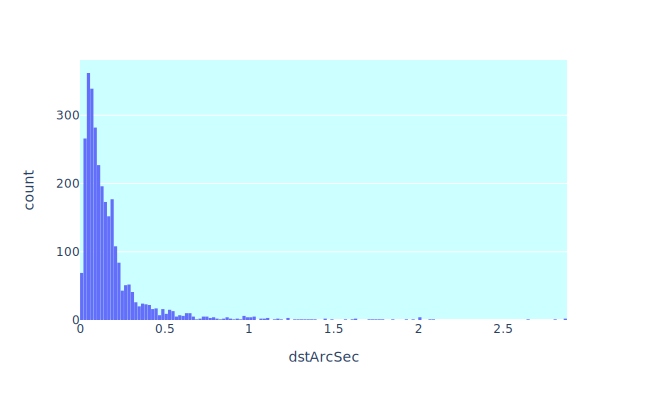

In [10]:
# Offsets histohram

fig = px.histogram(
    pstarrs, x='dstArcSec',
    width=647,
    height=400)
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

In [11]:
# Calculating RA, Dec in degrees to match the sources

def ra_to_deg(x):
    hms = x.split()
    return (int(hms[0])+(int(hms[1])+float(hms[2])/60)/60) * 15
    
    
def del_to_deg(x):
    dms = x.split()
    if dms[0][0] == '-':
        return int(dms[0]) - (int(dms[1])+float(dms[2])/60)/60
    else:
        return int(dms[0]) + (int(dms[1])+float(dms[2])/60)/60


bzcat['ra_deg'] = bzcat['RA (J2000.0)'].apply(ra_to_deg)
bzcat['dec_deg'] = bzcat['Dec (J2000.0)'].apply(del_to_deg)

In [12]:
# Source names based on their coordinates in degrees

bzcat['Source_name_deg'] = bzcat.apply(
    lambda x: '{:07.3f}'.format(x['ra_deg']) 
    + '{:+07.3f}'.format(x['dec_deg']), axis=1
)

pstarrs['Source_name_deg'] = pstarrs.apply(
    lambda x: '{:07.3f}'.format(x['_ra_']) 
    + '{:+07.3f}'.format(x['_dec_']), axis=1
)

In [13]:
# Adding data to the dataset
pstarrs.drop(['objName', '_ra_', '_dec_'],
             axis=1, inplace=True)
pstarrs.rename(columns={'dstArcSec': 'PSTARRS_offset'}, inplace=True)
bzcat = bzcat.merge(pstarrs, how='left', on='Source_name_deg')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,iMeanPSFMagMin,iMeanPSFMagMax,zMeanPSFMag,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,yMeanPSFMag,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,18.2309,18.316999,18.0620,11.0,17.969299,18.155001,18.2819,19.0,18.043301,18.384399
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,20.7754,21.674900,20.6894,5.0,20.501801,21.077000,20.2288,1.0,20.228800,20.228800


### Adding the GALEX data

In [14]:
# Data scraped from the MAST database via ./scraper_galex.ipynb (astroquery.mast)
galex = pd.read_excel('data/GALEX_data.xlsx')
galex = galex[['Source', 'GALEX_offset', 'fuv_mag', 'nuv_mag', 'e_bv']]
galex.rename(columns={'Source': 'BZCAT5 Source name'}, inplace=True)
galex.replace('--', np.NaN, inplace=True)
galex.head(3)

,BZCAT5 Source name,GALEX_offset,fuv_mag,nuv_mag,e_bv
0,5BZQJ0000-3221,0.096422,NaN,19.006159,0.009960
1,5BZQJ0001-1551,0.164426,NaN,20.242603,0.028843
2,5BZBJ0001-0746,0.642668,19.750713,19.134195,0.031354


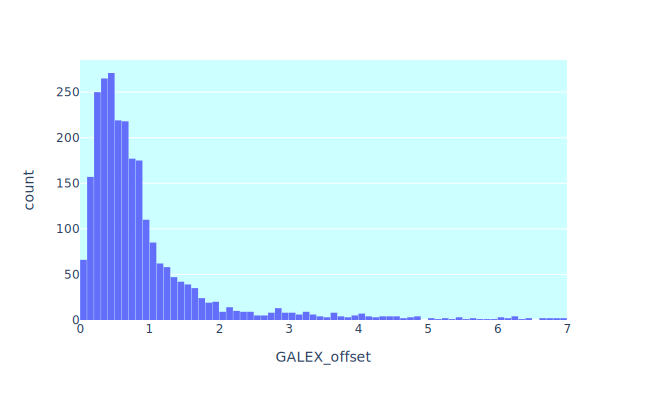

In [15]:
# Offsets histohram

fig = px.histogram(
    galex, x='GALEX_offset',
    width=647,
    height=400)
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

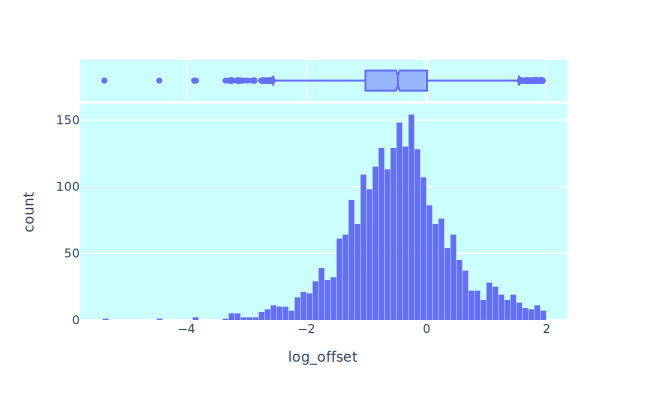

In [16]:
# Logarithmic histogram

galex['log_offset'] = np.log(galex['GALEX_offset'])
fig = px.histogram(
    galex, x='log_offset',
    width=647,
    height=400,
    marginal='box')
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

GALEX resolution FWHM = 4 arcsec. I'll leave all the mesurements.

In [17]:
# Adding GALEX data to the dataset

galex.drop(['log_offset'], axis=1, inplace=True)
bzcat = bzcat.merge(galex, how='left', on='BZCAT5 Source name')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,zMeanPSFMagMin,zMeanPSFMagMax,yMeanPSFMag,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax,GALEX_offset,fuv_mag,nuv_mag,e_bv
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.096422,NaN,19.006159,0.009960
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,17.969299,18.155001,18.2819,19.0,18.043301,18.384399,0.164426,NaN,20.242603,0.028843
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,20.501801,21.077000,20.2288,1.0,20.228800,20.228800,NaN,NaN,NaN,NaN


### Adding the WISE and 2MASS data

In [18]:
# Data scraped the WISE database via ./scraper_wise.ipynb
wise = pd.read_excel('data/WISE_data.xlsx')
wise.replace('--', np.NaN, inplace=True)
wise.head(3)

,Unnamed: 0,Source,w1,w1_err,w2,w2_err,w3,w3_err,w4,w4_err,J,J_err,H,H_err,K,K_err,offset_arcs
0,0,5BZQJ0000-3221,14.812000,0.032,13.458,0.031,10.198,0.068,7.731,0.168,NaN,NaN,NaN,NaN,NaN,NaN,0.298005
1,1,5BZQJ0001-1551,15.120000,0.036,13.938,0.040,10.511,0.090,8.371,0.383,NaN,NaN,NaN,NaN,NaN,NaN,0.233935
2,2,5BZQJ0001+1914,16.287001,0.072,15.260,0.100,11.796,NaN,9.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353622


In [19]:
#Converting non-detections to NaN.  Non-detections are those where w_err == NaN

def no_detections(x):
    if np.isnan(x['w1_err']):
        x['w1'] = np.NaN
    if np.isnan(x['w2_err']):
        x['w2'] = np.NaN
    if np.isnan(x['w3_err']):
        x['w3'] = np.NaN
    if np.isnan(x['w4_err']):
        x['w4'] = np.NaN
    return x    


wise = wise.apply(no_detections, axis=1)
wise.head(3)

,Unnamed: 0,Source,w1,w1_err,w2,w2_err,w3,w3_err,w4,w4_err,J,J_err,H,H_err,K,K_err,offset_arcs
0,0,5BZQJ0000-3221,14.812000,0.032,13.458,0.031,10.198,0.068,7.731,0.168,NaN,NaN,NaN,NaN,NaN,NaN,0.298005
1,1,5BZQJ0001-1551,15.120000,0.036,13.938,0.040,10.511,0.090,8.371,0.383,NaN,NaN,NaN,NaN,NaN,NaN,0.233935
2,2,5BZQJ0001+1914,16.287001,0.072,15.260,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353622


Looking for the maximum possible offset for cross-identification between the BZCAT and WISE coordinates. WISE angular resolution is about 6 arcseconds. The scraping was made by a "cone search" method with a radius parameter 0.0025 deg, which is about 9 arcseconds (it looked like the minimum possible to find the objects)

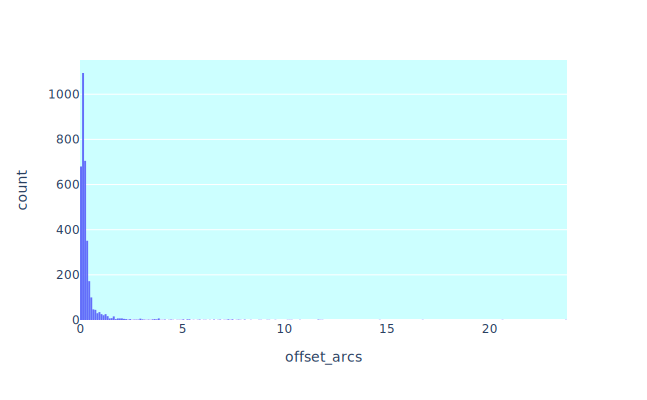

In [20]:
# Offsets histohram

fig = px.histogram(
    wise, x='offset_arcs',
    width=647,
    height=400)
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

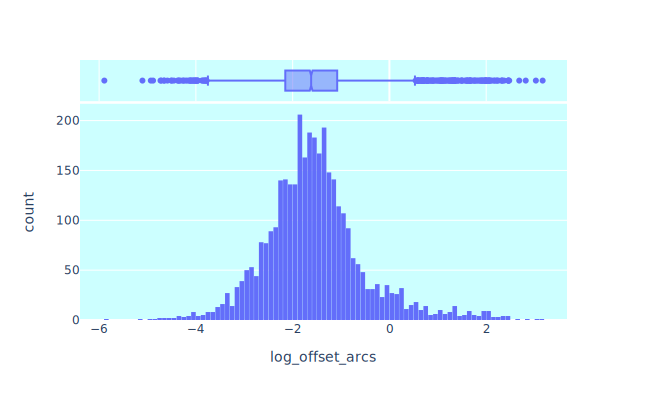

In [21]:
# Logarithmic histogram

wise['log_offset_arcs'] = np.log(wise['offset_arcs'])
fig = px.histogram(
    wise, x='log_offset_arcs',
    width=647,
    height=400,
    marginal='box')
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

The upper fence = 0.53 in the log scale, or 1.7 arcseconds.

The WISE resolution is 6 arcseconds though. I'll take $1.5 R$ as the offset limit: 9 arceconds, or 2.2 in the log scale.

In [22]:
# Dropping identifications with offsets >= 9 arcseconds

print(wise.shape[0])
mask = wise['offset_arcs'] < 9
wise = wise[mask]
print(wise.shape[0])

3524
3509


In [23]:
# Adding WISE data to the dataset

wise.drop([
    'Unnamed: 0', 'log_offset_arcs', 
    'w1_err', 'w2_err', 'w3_err', 'w4_err', 
    'J_err', 'H_err', 'K_err'], 
    axis=1, inplace=True)
wise.rename(columns={'Source': 'BZCAT5 Source name', 'offset_arcs': 'WISE_offset'}, 
            inplace=True)
bzcat = bzcat.merge(wise, how='left', on='BZCAT5 Source name')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,nuv_mag,e_bv,w1,w2,w3,w4,J,H,K,WISE_offset
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,19.006159,0.009960,14.812000,13.458,10.198,7.731,NaN,NaN,NaN,0.298005
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,20.242603,0.028843,15.120000,13.938,10.511,8.371,NaN,NaN,NaN,0.233935
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,NaN,NaN,16.287001,15.260,NaN,NaN,NaN,NaN,NaN,0.353622


### Adding the NED data on extinction

In [24]:
extinct = pd.read_excel('data/NED_extinction.xlsx')
extinct.drop(['Unnamed: 0', 'RA (J2000.0)', 'Dec (J2000.0)'], 
             axis=1, inplace=True)
bzcat = bzcat.merge(extinct, how='left', on='BZCAT5 Source name')
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,ext_SDSS_u,ext_SDSS_g,ext_SDSS_r,ext_SDSS_i,ext_SDSS_z,ext_PS1_g,ext_PS1_r,ext_PS1_i,ext_PS1_z,ext_PS1_y
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,0.043,0.033,0.023,0.017,0.013,0.032,0.023,0.017,0.013,0.011
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.123,0.096,0.066,0.049,0.037,0.092,0.066,0.049,0.038,0.031
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.176,0.137,0.095,0.070,0.052,0.132,0.094,0.070,0.055,0.045


In [25]:
bzcat.drop(['Source', 'Source_name_deg', 'ra_deg', 'dec_deg'], 
           axis=1, inplace=True)
bzcat.to_csv('data/BZCAT_combined.csv', index=False)